# Exercise 8: Artificial Neural Networks and Bias/Variance

## Exercise 8 Overview: Artificial Neural Networks and Regularization

In Exercise 8, we explore advanced topics in machine learning, specifically:

1. **Regularization in Linear and Logistic Regression**:
   - Implementing regularization techniques (L2/Ridge) in linear and logistic regression to reduce model complexity.
   - We examine how to tune the regularization parameter \(\lambda\) using cross-validation and evaluate its effects on model performance and coefficients.

2. **Artificial Neural Networks (ANNs)**:
   - Introduction to neural networks for classification tasks, focusing on using one hidden layer with different activation functions.
   - Learn to structure ANNs in PyTorch, apply cross-validation, and visualize decision boundaries.
   - Experiment with the number of hidden units to understand its impact on the model's learning capacity and generalization.

3. **Multiclass Classification Using ANNs and Multinomial Regression**:
   - Extend ANNs and logistic regression to multiclass problems using the softmax function and cross-entropy loss.
   - Evaluate the decision boundaries on synthetic datasets to observe the model’s classification patterns.

### Objectives:
- Understand the role of regularization in regression and classification.
- Explore ANNs' flexibility and constraints in modeling complex patterns.
- Apply cross-validation to optimize model parameters, including the number of hidden units and regularization strength.
- Experiment with different types of neural networks and regularization for both binary and multiclass tasks.

This exercise provides foundational insights into deep learning and the effects of regularization on model performance, offering practical skills in PyTorch for building and evaluating neural networks.

## Exercise 8.1: Regularized Linear Regression

In this section, we focus on **Regularized Linear Regression** with **L2 regularization** (Ridge regression). The main objectives are:

1. **Understanding Regularization**:
   - We implement L2 regularization to penalize large weights in linear regression, reducing overfitting and improving generalization.

2. **Parameter Selection**:
   - Using **cross-validation** to optimize the regularization parameter \(\lambda\), balancing model complexity with prediction accuracy.

3. **Performance Evaluation**:
   - Analyze the effects of different \(\lambda\) values on both the training and validation errors.
   - Evaluate how regularization impacts the regression coefficients and interpret the results.

By the end of this section, we’ll understand how to apply regularization to a linear regression model, select optimal \(\lambda\) values using cross-validation, and interpret regularization’s effects on the model.

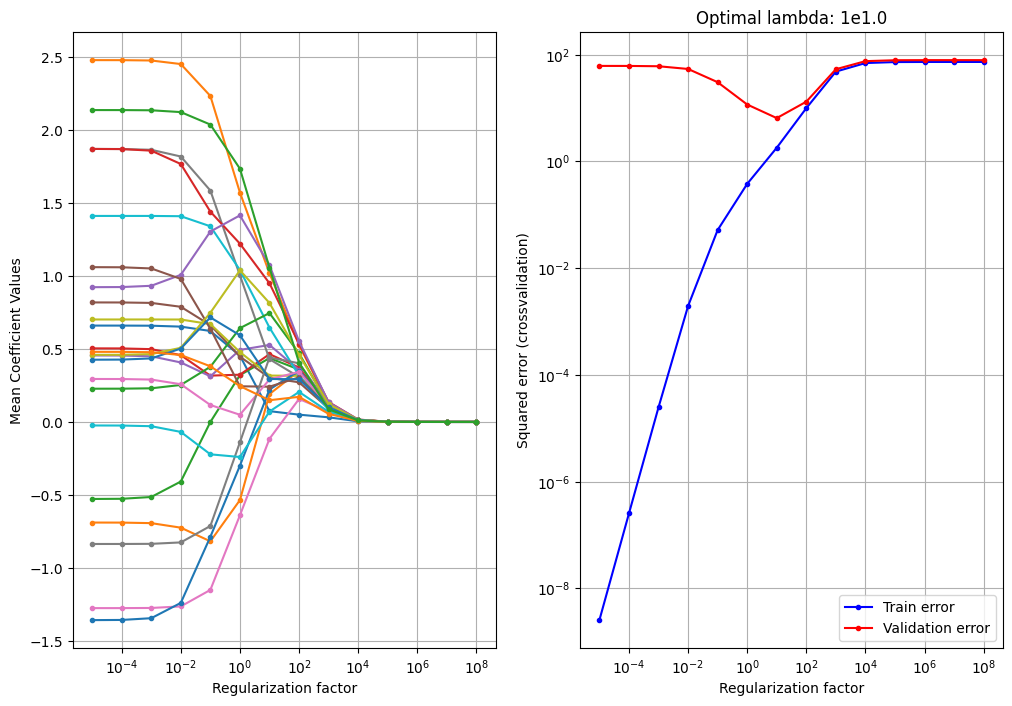

Linear regression without feature selection:
- Training error: 7.7316485564466605e-22
- Test error:     2340.5832213346184
- R^2 train:     1.0
- R^2 test:     -37.866382576131855

Regularized linear regression:
- Training error: 1.3863826783917887
- Test error:     6.357314636670547
- R^2 train:     0.9800311471400753
- R^2 test:     0.8944340792613261

Weights in last fold:
         Offset           77.39
     biacromial            0.09
 pelvic.breadth            0.14
 bitrochanteric            0.44
    chest.depth            0.44
     chest.diam            0.52
     elbow.diam            0.31
     wrist.diam           -0.15
      knee.diam            0.45
     ankle.diam            0.32
 shoulder.girth            0.67
    chest.girth            0.19
    waist.girth            1.07
    navel.girth            0.76
      hip.girth            0.99
    thigh.girth            1.13
    bicep.girth            0.24
  forearm.girth            0.27
     knee.girth            0.42
     calf.gir

In [1]:
# exercise 8.1.1

import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import rlr_validate

filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")


mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")


### Exercise 8.1.2: Logistic Regression with Regularization

In this exercise, we use **logistic regression** to classify red and white wines, focusing on the role of regularization in binary classification.

#### Key Objectives:
1. **Dataset Standardization**: Standardize the dataset to ensure feature comparability.
2. **Regularization Parameter Selection**:
   - Use **hold-out cross-validation** to select the optimal regularization strength.
3. **Effect of Training Set Size**:
   - Experiment with different training set sizes to observe the impact on model performance and the stability of the coefficients.
4. **Analysis**:
   - Examine how regularization influences coefficient magnitudes and model performance, particularly with small training sets.

This exercise demonstrates how regularization and dataset size affect logistic regression in binary classification.

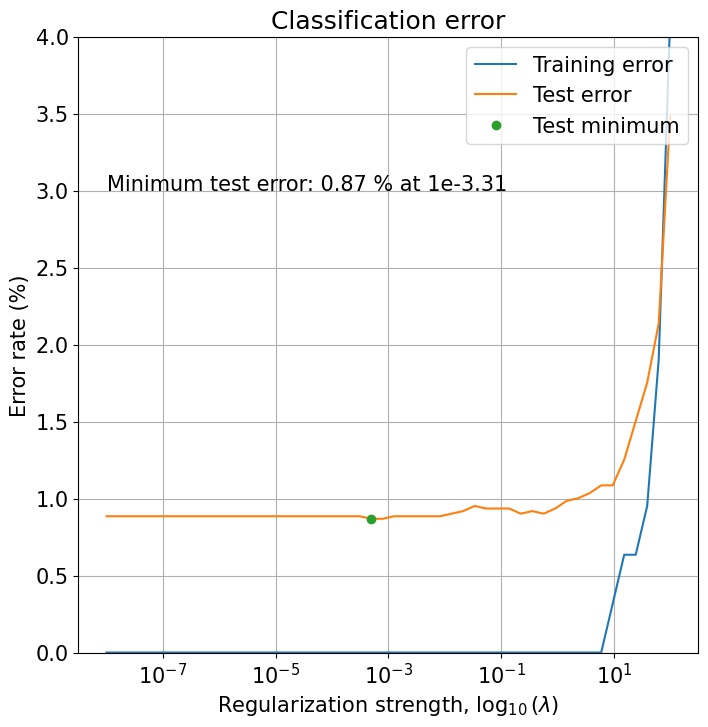

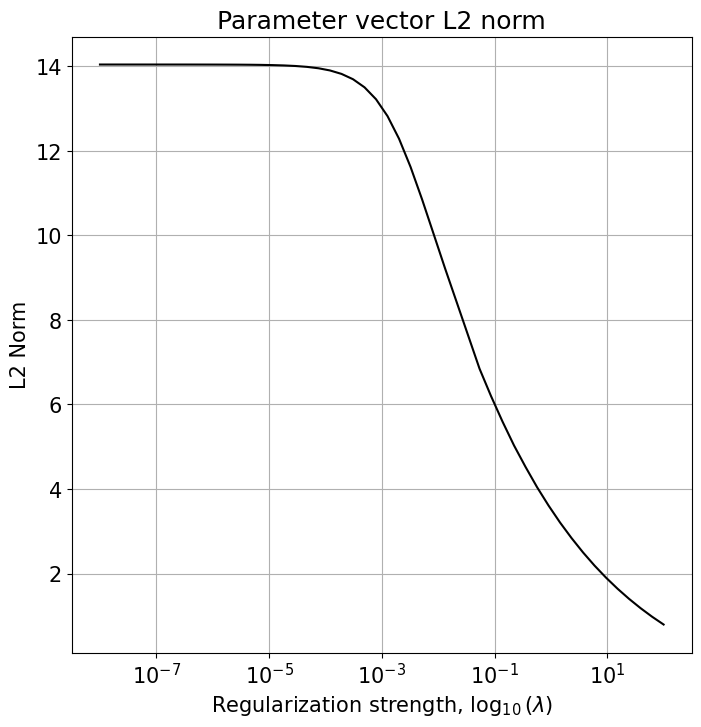

Ran Exercise 9.1.1


In [2]:
# exercise 8.1.2

import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from dtuimldmtools import confmatplot, rocplot

filename = importlib_resources.files("dtuimldmtools").joinpath("data/wine2.mat")

font_size = 15
plt.rcParams.update({"font.size": font_size})

# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"].squeeze()
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
classNames = [name[0][0] for name in mat_data["classNames"]]
N, M = X.shape
C = len(classNames)


# Create crossvalidation partition for evaluation
# using stratification and 95 pct. split between training and test
K = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, stratify=y)
# Try to change the test_size to e.g. 50 % and 99 % - how does that change the
# effect of regularization? How does differetn runs of  test_size=.99 compare
# to eachother?

# Standardize the training and set set based on training set mean and std
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Fit regularized logistic regression model to training data to predict
# the type of wine
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty="l2", C=1 / lambda_interval[k])

    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0]
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

plt.figure(figsize=(8, 8))
# plt.plot(np.log10(lambda_interval), train_error_rate*100)
# plt.plot(np.log10(lambda_interval), test_error_rate*100)
# plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate * 100)
plt.semilogx(lambda_interval, test_error_rate * 100)
plt.semilogx(opt_lambda, min_error * 100, "o")
plt.text(
    1e-8,
    3,
    "Minimum test error: "
    + str(np.round(min_error * 100, 2))
    + " % at 1e"
    + str(np.round(np.log10(opt_lambda), 2)),
)
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.ylabel("Error rate (%)")
plt.title("Classification error")
plt.legend(["Training error", "Test error", "Test minimum"], loc="upper right")
plt.ylim([0, 4])
plt.grid()
plt.show()

plt.figure(figsize=(8, 8))
plt.semilogx(lambda_interval, coefficient_norm, "k")
plt.ylabel("L2 Norm")
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.title("Parameter vector L2 norm")
plt.grid()
plt.show()

print("Ran Exercise 9.1.1")


## Exercise 8.2: Artificial Neural Networks (ANNs)

In this section, we explore **Artificial Neural Networks (ANNs)** for classification tasks, focusing on building and training simple neural networks. The key objectives are:

1. **Network Architecture**:
   - Experiment with a single hidden layer and analyze how different configurations impact performance.
   - Implement networks using PyTorch, focusing on tuning the number of hidden units.

2. **Activation Functions**:
   - Compare activation functions (e.g., ReLU, Sigmoid) and assess their impact on learning.

3. **Cross-Validation**:
   - Use cross-validation to evaluate model performance and optimize parameters like the number of hidden units.

4. **Decision Boundaries**:
   - Visualize decision boundaries to understand how the network separates classes.

This exercise demonstrates the flexibility of ANNs and the impact of architectural choices on classification performance.

### Exercise 8.2.1

In the given neural network with two input units (\( X_1 \) and \( X_2 \)), two hidden units (\( H_1 \) and \( H_2 \)), and one output unit (\( Y_1 \)), we are asked to calculate the network output \( y_{\text{est}} \) under two scenarios:

1. Using a **linear (purelin)** transfer function in the hidden layer, defined as \( g_{\text{hidden}}(t) = t \).
2. Changing the hidden layer transfer function to a **ReLU** function, defined as \( g_{\text{hidden}}(t) = \max(0, t) \).

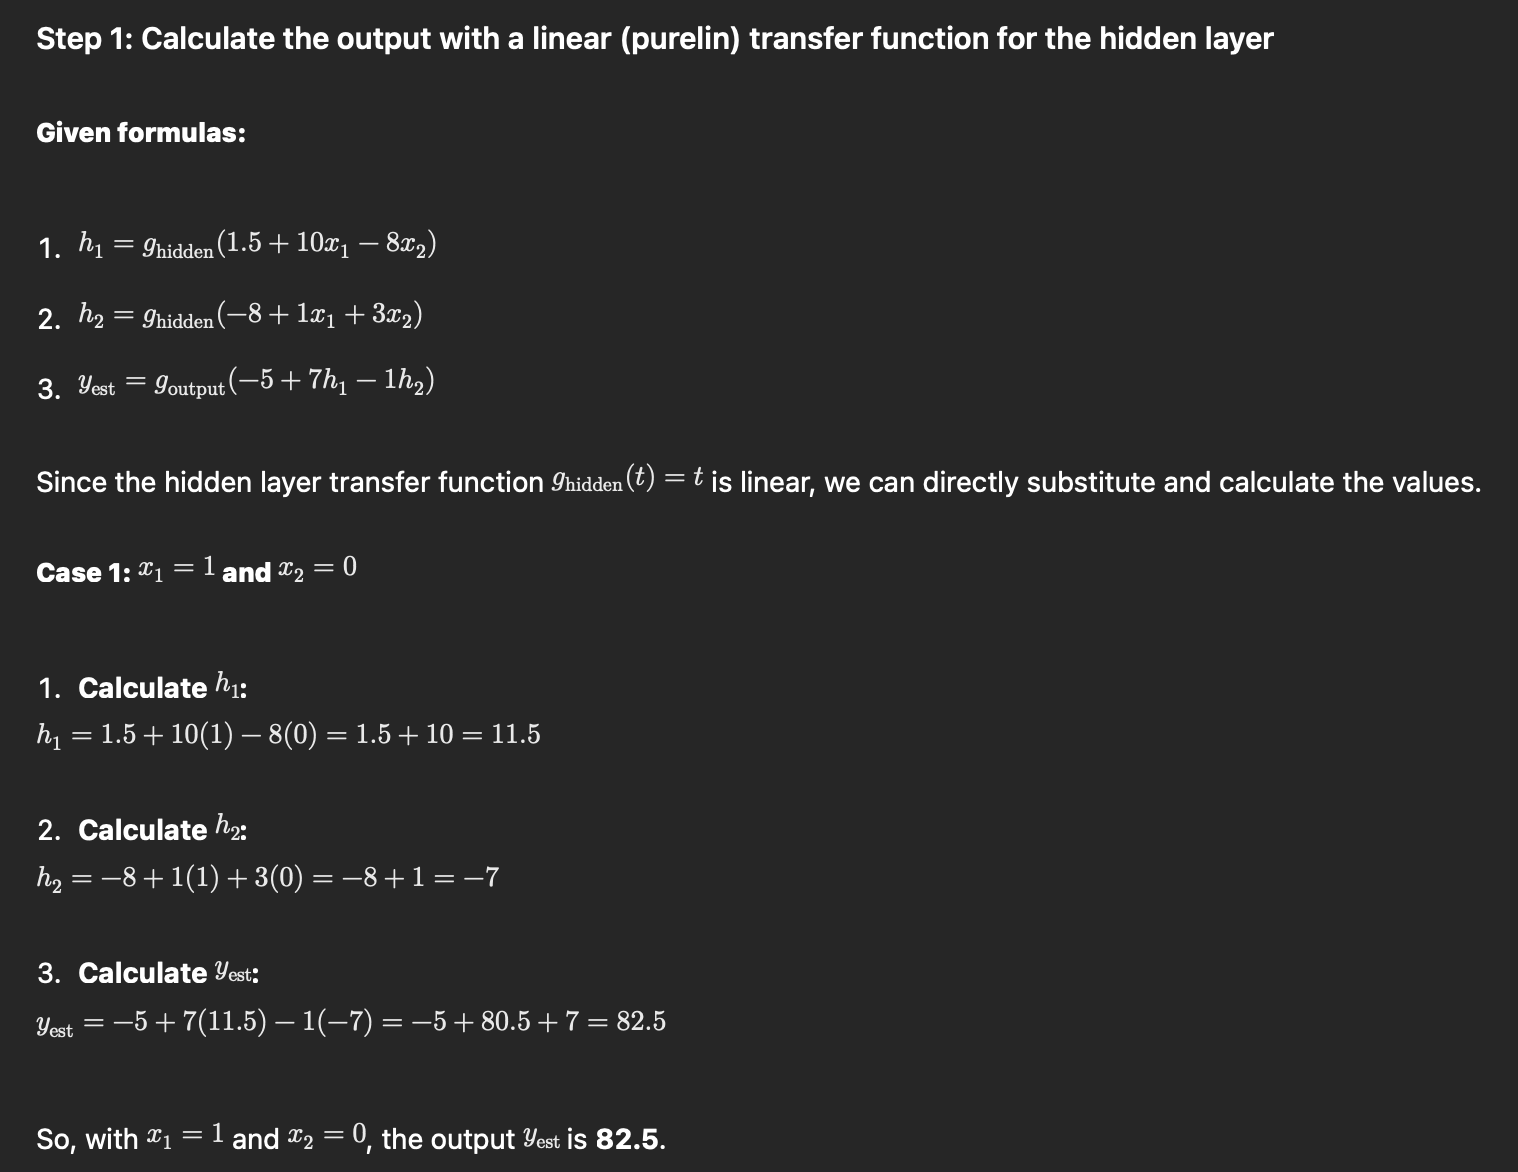

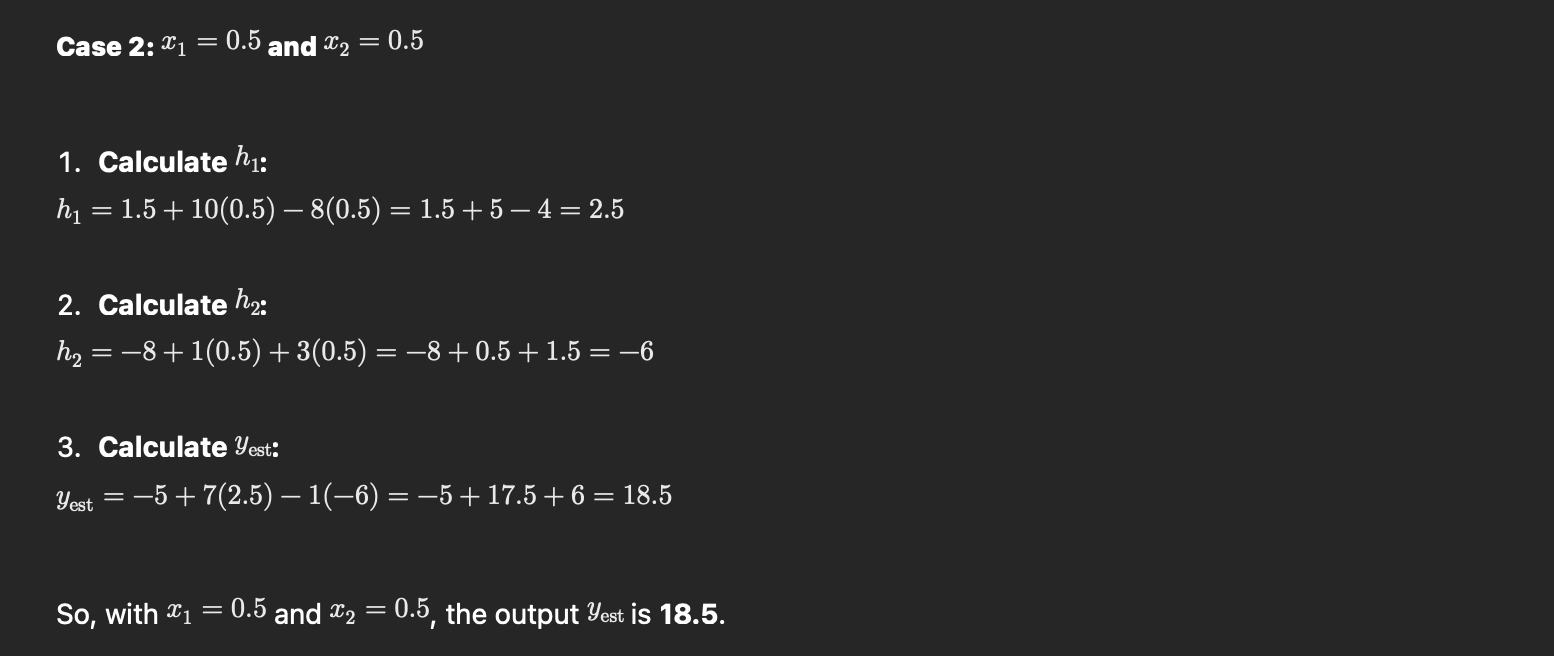

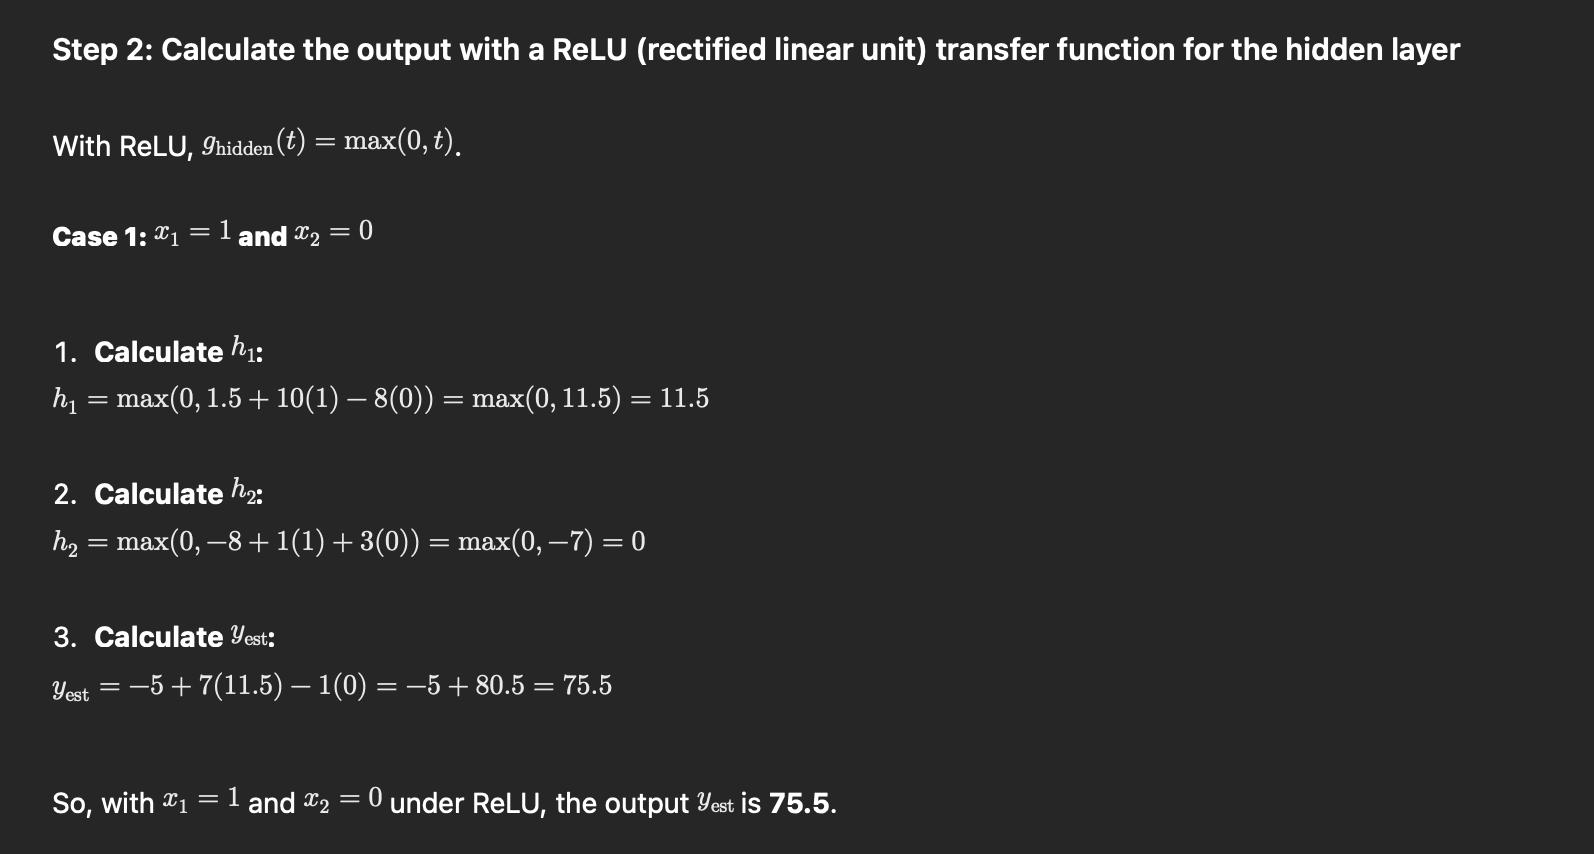

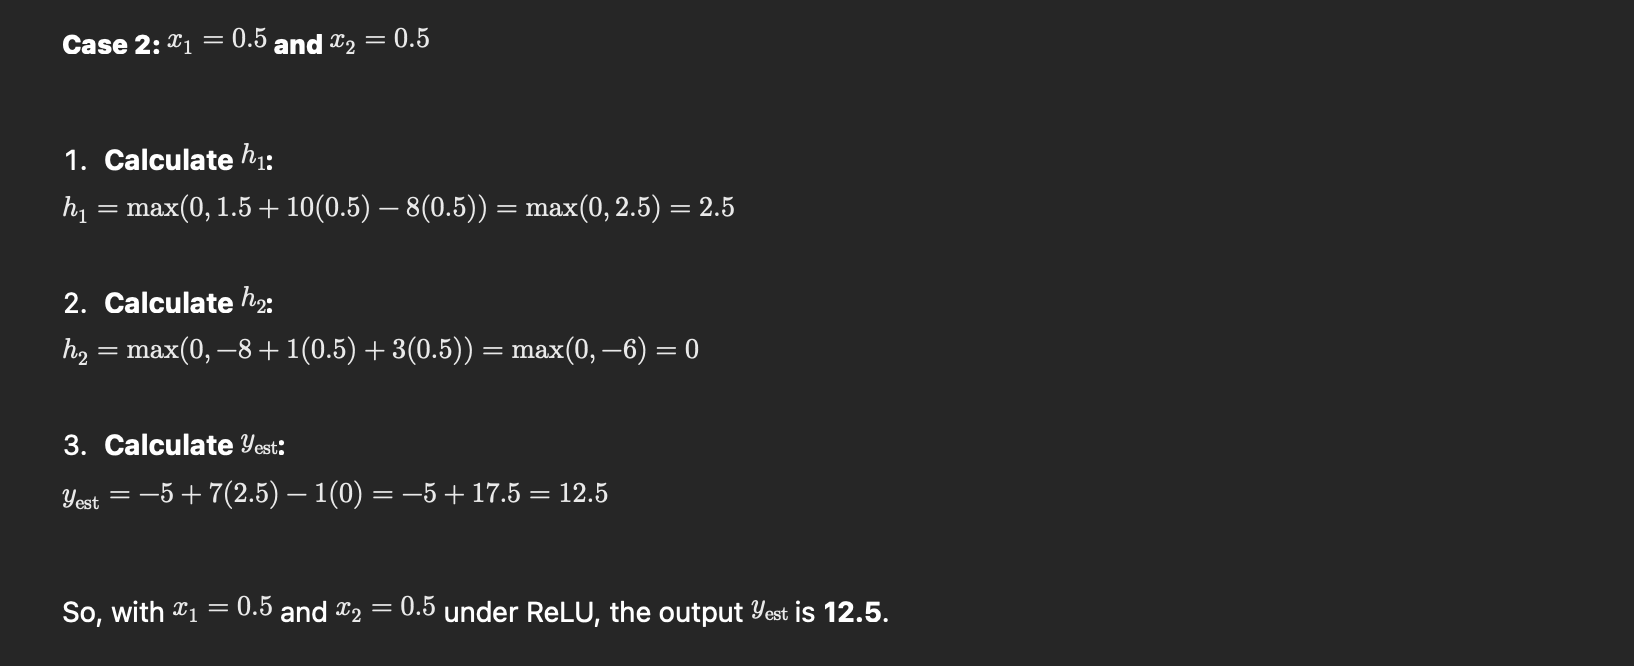

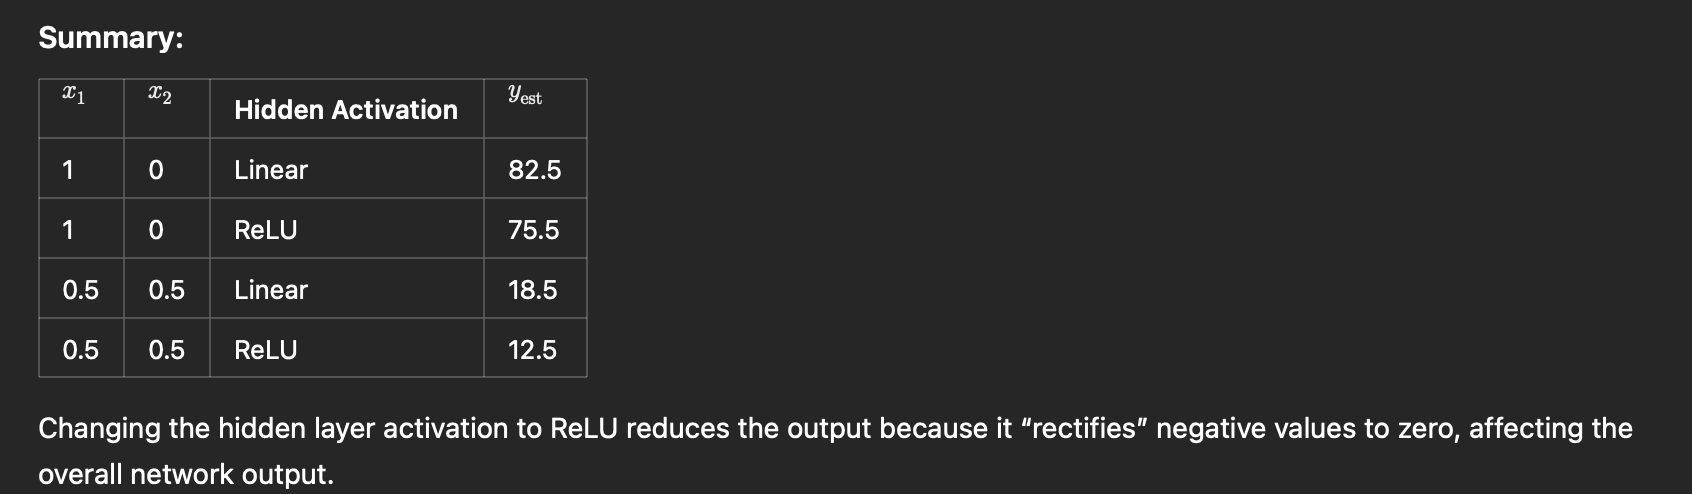

### Exercise 8.2.2: Neural Network Classification on XOR Dataset

In this exercise, we use a neural network to classify the **XOR dataset**, which is a classic example of a non-linearly separable problem. The main objectives are:

1. **Data Loading**: Load the XOR dataset from a `.mat` file using `loadmat()`.
2. **Network Definition**: Build a simple neural network using PyTorch, with an architecture that can capture non-linear patterns.
3. **K-Fold Cross-Validation**: Implement K-fold cross-validation to estimate the model’s performance across different data splits.
4. **Decision Boundary Visualization**: Plot the decision boundaries to visually evaluate the network's ability to classify the XOR dataset.

This exercise demonstrates how neural networks can be applied to non-linearly separable data, highlighting the importance of hidden layers and activation functions in learning complex patterns.

Training model of type:
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.50153565	0.00028858945
		2000	0.4179619	0.00010744346
		3000	0.38837916	4.964516e-05
		4000	0.37430602	2.722937e-05
		5000	0.36646608	1.6345766e-05
		6000	0.3617042	1.0381559e-05
		7000	0.3586379	6.814042e-06
		8000	0.35657135	4.680472e-06
		9000	0.3551235	3.52467e-06
		10000	0.3540723	2.6092682e-06
		Final loss:
		10000	0.3540723	2.6092682e-06

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.6532213	0.00012900696
		2000	0.40901655	0.00071726216
		3000	0.21396457	0.00056149566
		4000	0.13205458	0.00041181257
		5000	0.09255287	0.00030460273
		6000	0.07117057	0.00022450161
		7000	0.058736507	0.00016259208
		8000	0.051172357	0.000115736824
		9000	0.046379976	8.336634e-05
		10000	0.043148763	6.3366584e-05
		Final loss:
		10000	0.04314

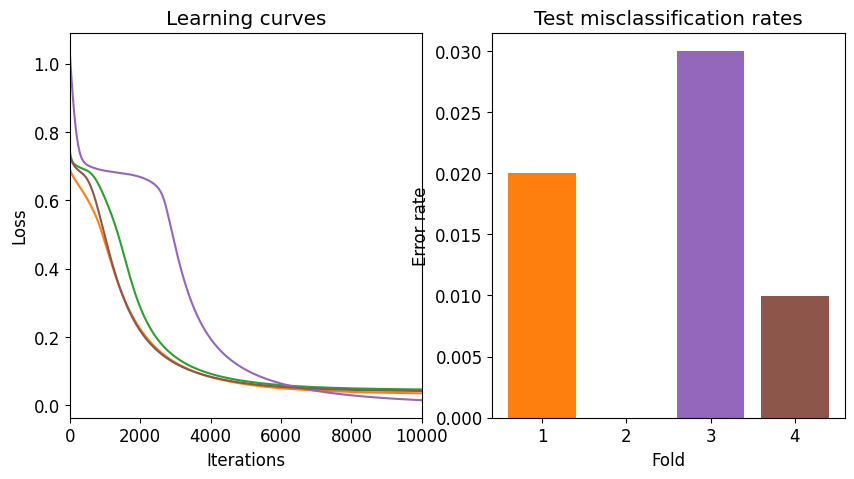

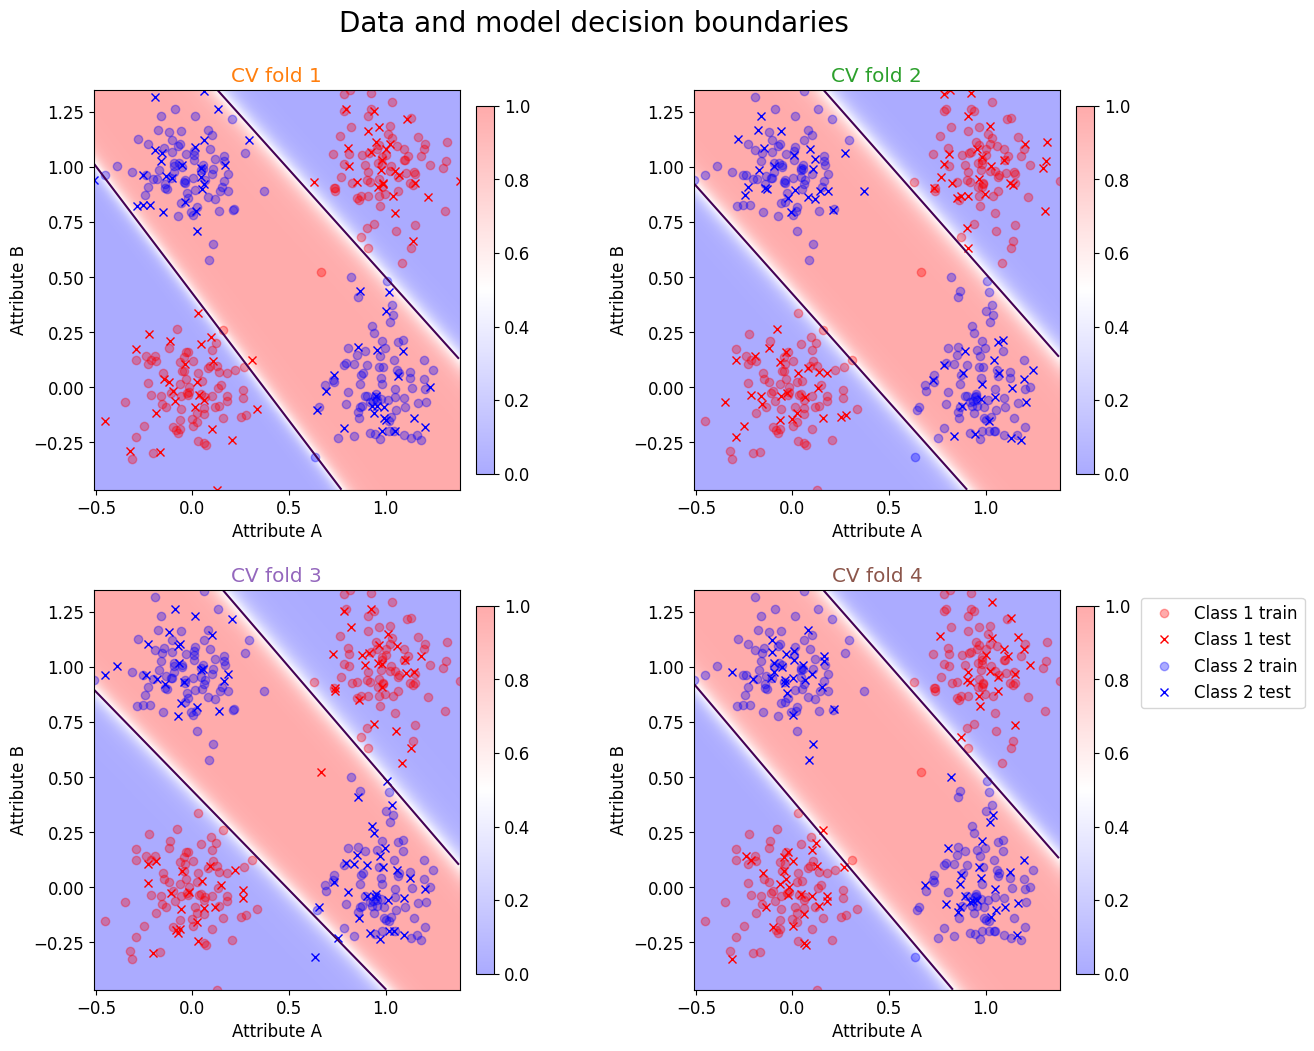

Diagram of best neural net in last fold:


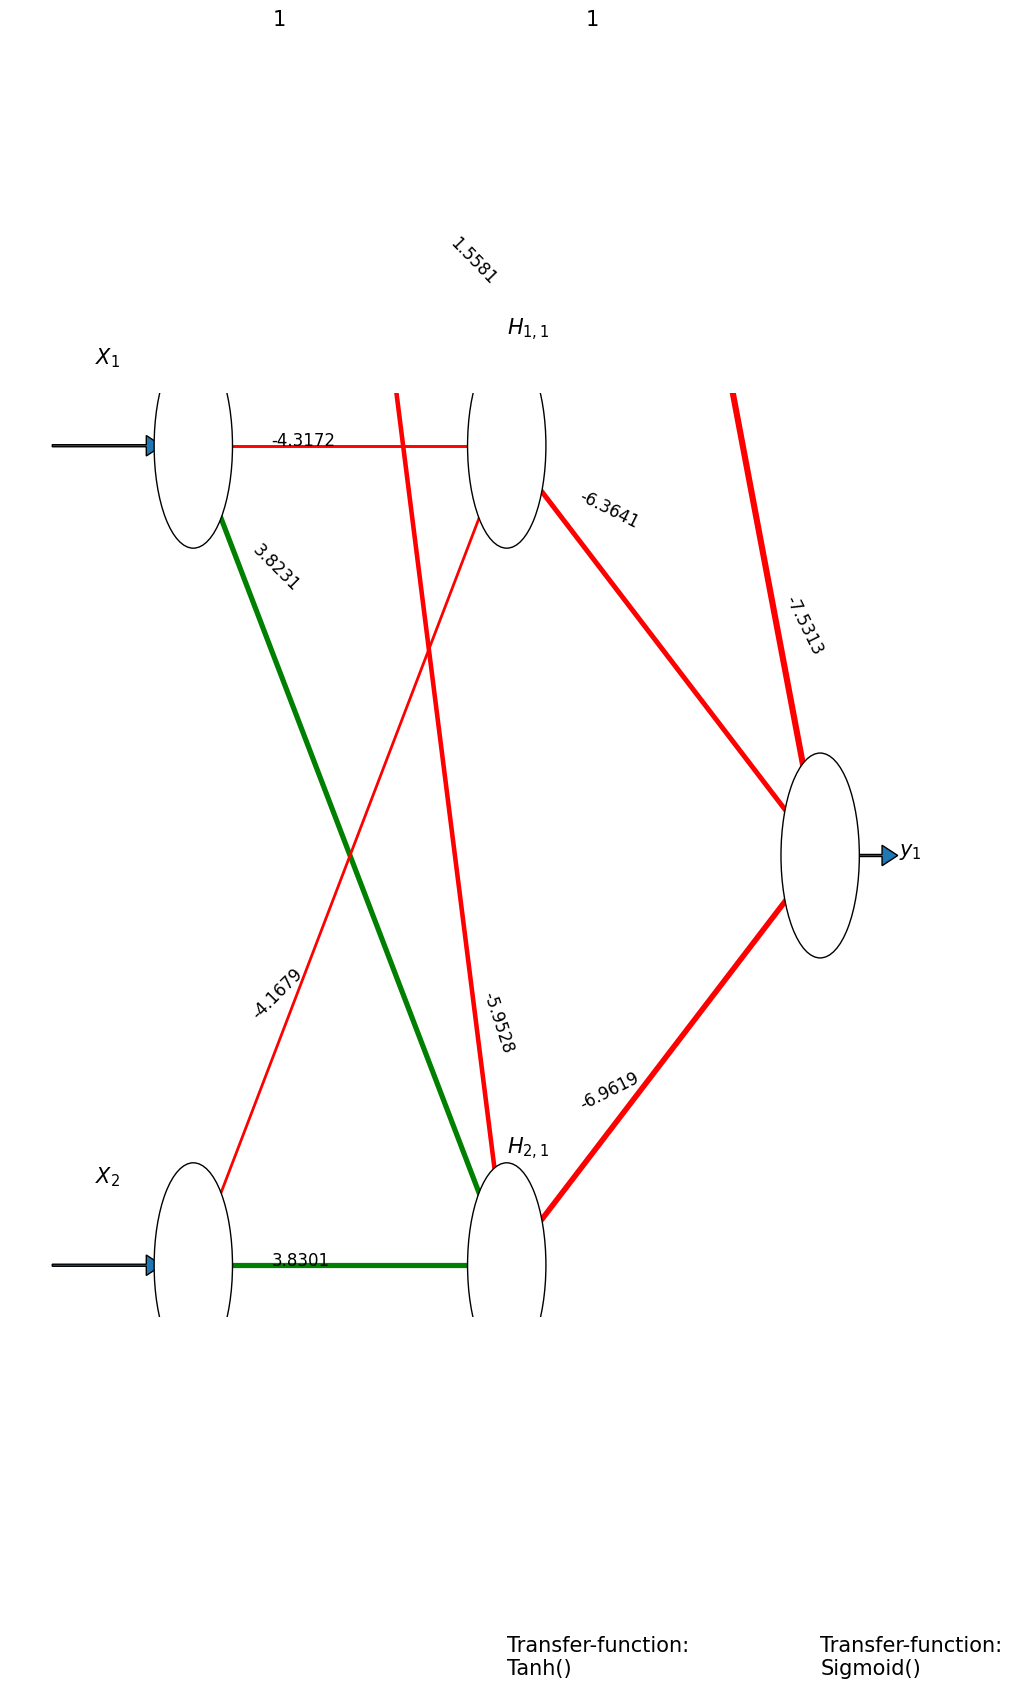


Generalization error/average error rate: 1.5%
Ran exercise 8.2.2.


In [4]:
# exercise 8.2.2
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import (
    draw_neural_net,
    train_neural_net,
    visualize_decision_boundary,
)

filename = importlib_resources.files("dtuimldmtools").joinpath("data/xor.mat")

plt.rcParams.update({"font.size": 12})

# read XOR DATA from matlab datafile
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"]

attributeNames = [name[0] for name in mat_data["attributeNames"].squeeze()]
classNames = [name[0] for name in mat_data["classNames"].squeeze()]
N, M = X.shape
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10, 10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K)))
subplot_size_2 = int(np.ceil(K / subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle("Data and model decision boundaries", fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]

# Define the model structure
n_hidden_units = 2  # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to H hiden units
    # 1st transfer function, either Tanh or ReLU:
    torch.nn.Tanh(),  # torch.nn.ReLU(),
    torch.nn.Linear(n_hidden_units, 1),  # H hidden units to 1 output neuron
    torch.nn.Sigmoid(),  # final tranfer function
)
# Since we're training a neural network for binary classification, we use a
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print("Training model of type:\n{}\n".format(str(model())))

# Do cross-validation:
errors = []  # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the
# indices to be used for training and testing in each split, and calling
# the enumerate-method with this simply returns this indices along with
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold,
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Go to the file 'dtuimldmtools.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(
        model, loss_fn, X=X_train, y=y_train, n_replicates=3, max_iter=max_iter
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)  # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > 0.5).type(
        dtype=torch.uint8
    )  # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float) / len(y_test)).data.numpy()
    errors.append(error_rate)  # store error rate for current CV fold

    # Make a subplot for current cross validation fold that displays the
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1, subplot_size_2, k + 1)
    plt.title("CV fold {0}".format(k + 1), color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(
        predict,
        X,
        y,  # provide data, along with function for prediction
        attributeNames,
        classNames,  # provide information on attribute and class names
        train=train_index,
        test=test_index,  # provide information on partioning
        show_legend=k == (K - 1),
    )  # only display legend for last plot

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the error rate across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("Error rate")
summaries_axes[1].set_title("Test misclassification rates")

# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print(
    "\nGeneralization error/average error rate: {0}%".format(
        round(100 * np.mean(errors), 4)
    )
)

print("Ran exercise 8.2.2.")

#### 8.2.3 n_hidden units increased

Training model of type:
Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.58608747	0.00017733201
		2000	0.5260362	6.0956536e-05
		3000	0.5051352	2.6666705e-05
		4000	0.49540925	1.4257e-05
		5000	0.4899643	8.576321e-06
		6000	0.4865601	5.7575667e-06
		7000	0.4842799	3.7538928e-06
		8000	0.4826822	2.5932059e-06
		9000	0.48152715	2.1042983e-06
		10000	0.4806723	1.3640274e-06
		Final loss:
		10000	0.4806723	1.3640274e-06

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.6108146	0.0001686912
		2000	0.5406996	7.704913e-05
		3000	0.5130889	3.4849265e-05
		4000	0.5000919	1.8592886e-05
		5000	0.49287924	1.1125578e-05
		6000	0.48844656	7.2606726e-06
		7000	0.48553884	5.033126e-06
		8000	0.48354504	3.451435e-06
		9000	0.48213282	2.5343475e-06
		10000	0.48110646	1.7964128e-06
		Final loss:
		10000	0.48110646	1.79641

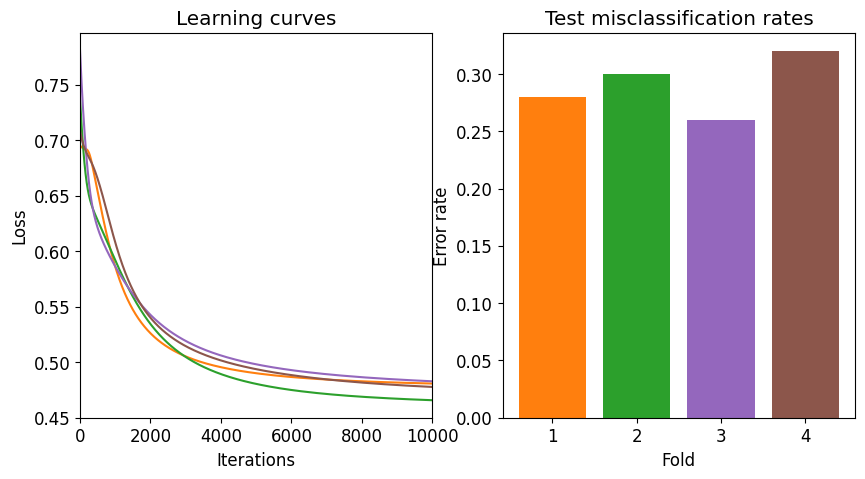

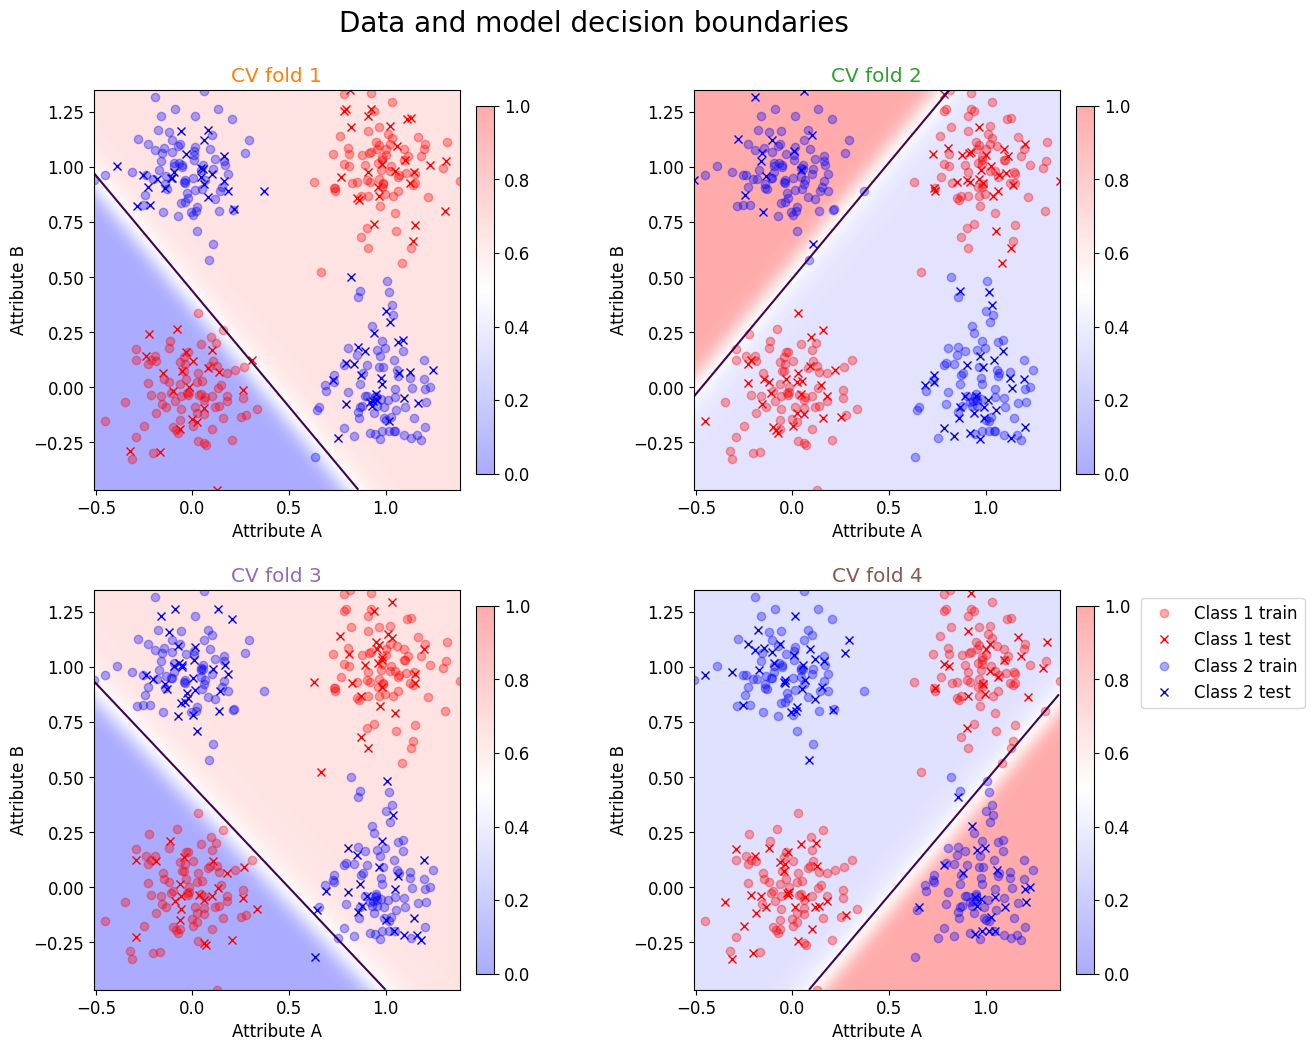

Diagram of best neural net in last fold:


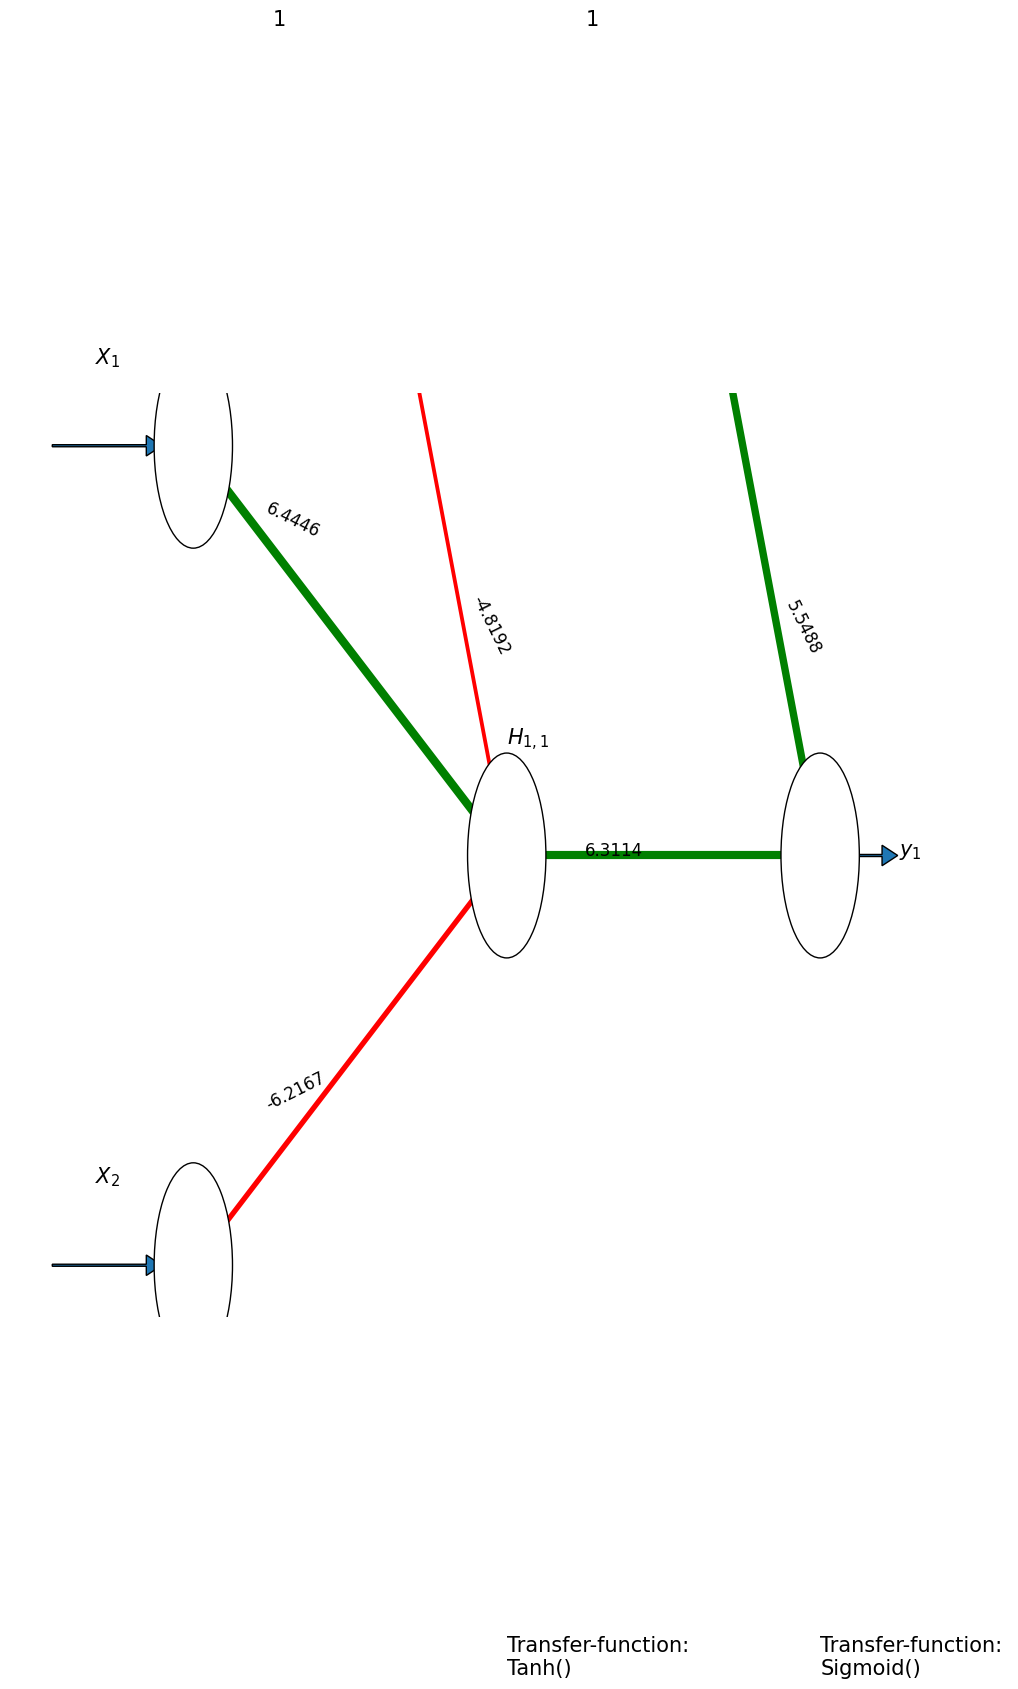


Generalization error/average error rate: 29.0%
Ran exercise 8.2.2.


In [5]:
# exercise 8.2.2
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import (
    draw_neural_net,
    train_neural_net,
    visualize_decision_boundary,
)

filename = importlib_resources.files("dtuimldmtools").joinpath("data/xor.mat")

plt.rcParams.update({"font.size": 12})

# read XOR DATA from matlab datafile
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"]

attributeNames = [name[0] for name in mat_data["attributeNames"].squeeze()]
classNames = [name[0] for name in mat_data["classNames"].squeeze()]
N, M = X.shape
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10, 10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K)))
subplot_size_2 = int(np.ceil(K / subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle("Data and model decision boundaries", fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]

# Define the model structure
n_hidden_units = 1  # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to H hiden units
    # 1st transfer function, either Tanh or ReLU:
    torch.nn.Tanh(),  # torch.nn.ReLU(),
    torch.nn.Linear(n_hidden_units, 1),  # H hidden units to 1 output neuron
    torch.nn.Sigmoid(),  # final tranfer function
)
# Since we're training a neural network for binary classification, we use a
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print("Training model of type:\n{}\n".format(str(model())))

# Do cross-validation:
errors = []  # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the
# indices to be used for training and testing in each split, and calling
# the enumerate-method with this simply returns this indices along with
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold,
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Go to the file 'dtuimldmtools.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(
        model, loss_fn, X=X_train, y=y_train, n_replicates=3, max_iter=max_iter
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)  # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > 0.5).type(
        dtype=torch.uint8
    )  # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float) / len(y_test)).data.numpy()
    errors.append(error_rate)  # store error rate for current CV fold

    # Make a subplot for current cross validation fold that displays the
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1, subplot_size_2, k + 1)
    plt.title("CV fold {0}".format(k + 1), color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(
        predict,
        X,
        y,  # provide data, along with function for prediction
        attributeNames,
        classNames,  # provide information on attribute and class names
        train=train_index,
        test=test_index,  # provide information on partioning
        show_legend=k == (K - 1),
    )  # only display legend for last plot

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the error rate across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("Error rate")
summaries_axes[1].set_title("Test misclassification rates")

# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print(
    "\nGeneralization error/average error rate: {0}%".format(
        round(100 * np.mean(errors), 4)
    )
)

print("Ran exercise 8.2.2.")

#### 8.2.4. n_hidden_units=10

Training model of type:
Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.13470468	0.002067316
		2000	0.035361297	0.0008476593
		3000	0.01876214	0.00048086402
		4000	0.012620442	0.00033145
		5000	0.0093968185	0.0002685171
		6000	0.0072468217	0.00026017442
		7000	0.005471794	0.00031197214
		8000	0.0037965146	0.00042549288
		9000	0.002363644	0.0005077321
		10000	0.0013963389	0.00053837535
		Final loss:
		10000	0.0013963389	0.00053837535

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.2503137	0.0019103504
		2000	0.061276212	0.0009745666
		3000	0.029102873	0.0005751759
		4000	0.018007468	0.00040675708
		5000	0.012559654	0.00032171584
		6000	0.009365686	0.00026851497
		7000	0.0072884336	0.00023710511
		8000	0.005770027	0.00023656663
		9000	0.0044715335	0.00028473922
		10000	0.0031664455	0.00042196104
		Fi

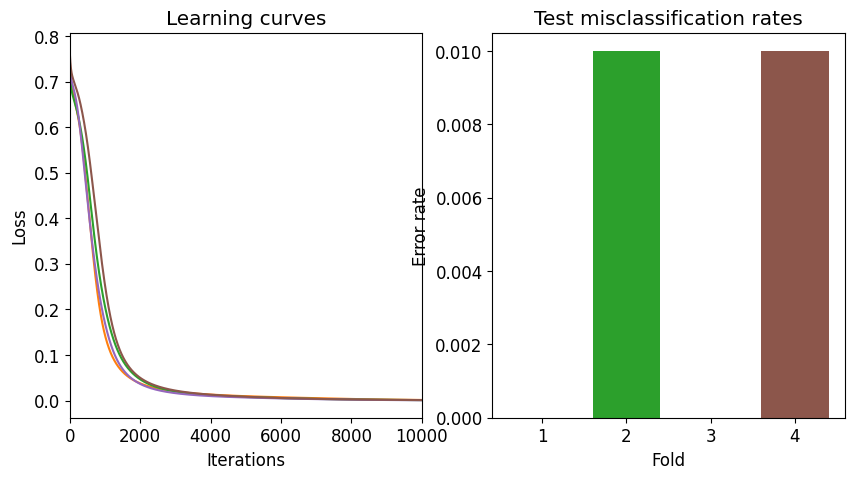

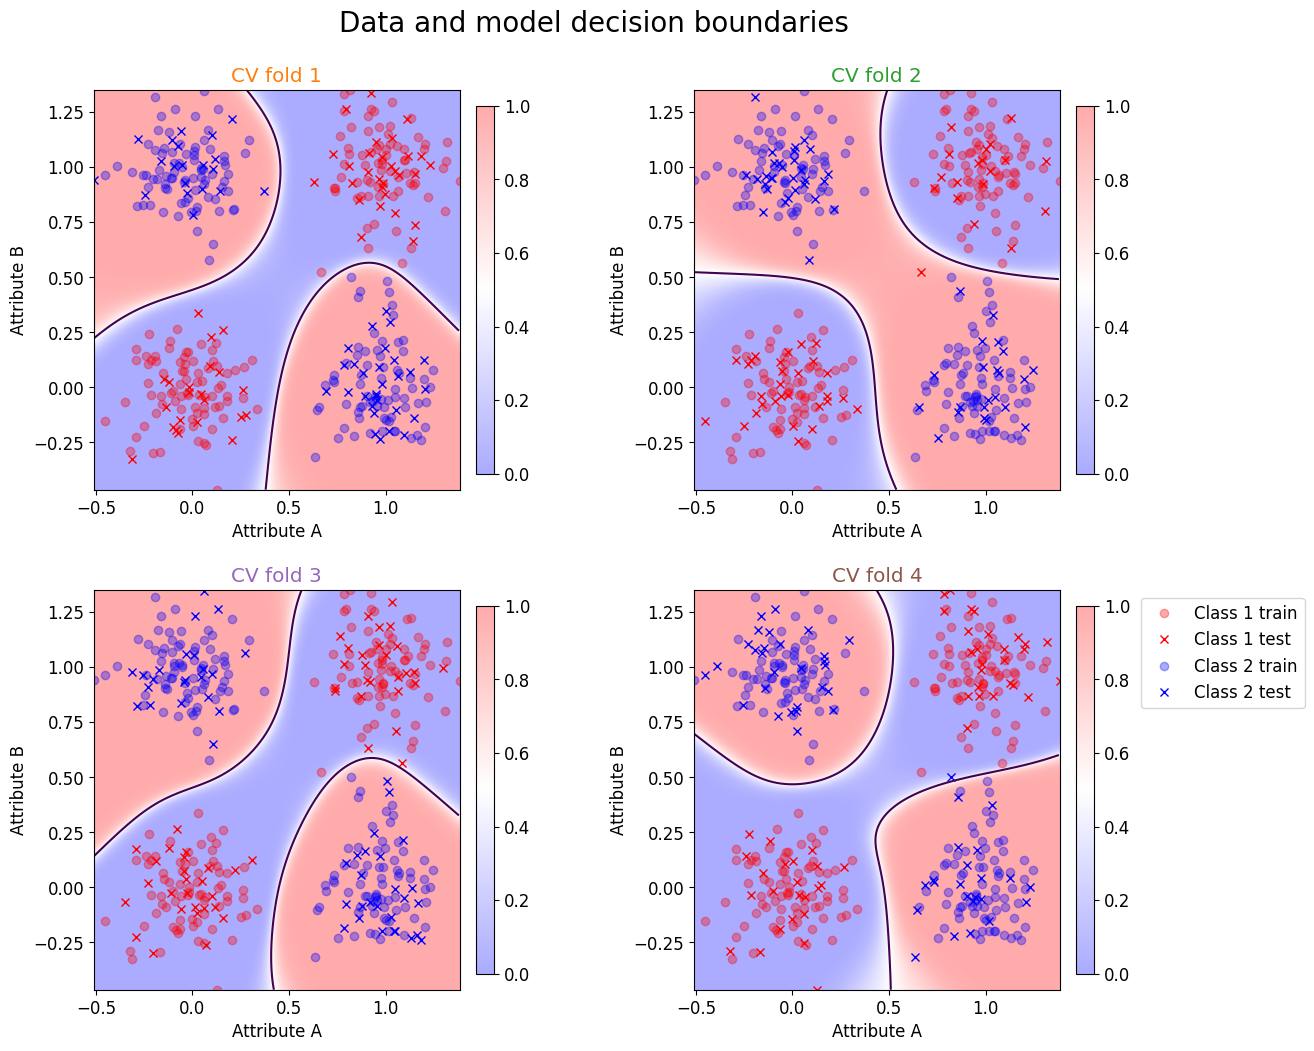

Diagram of best neural net in last fold:


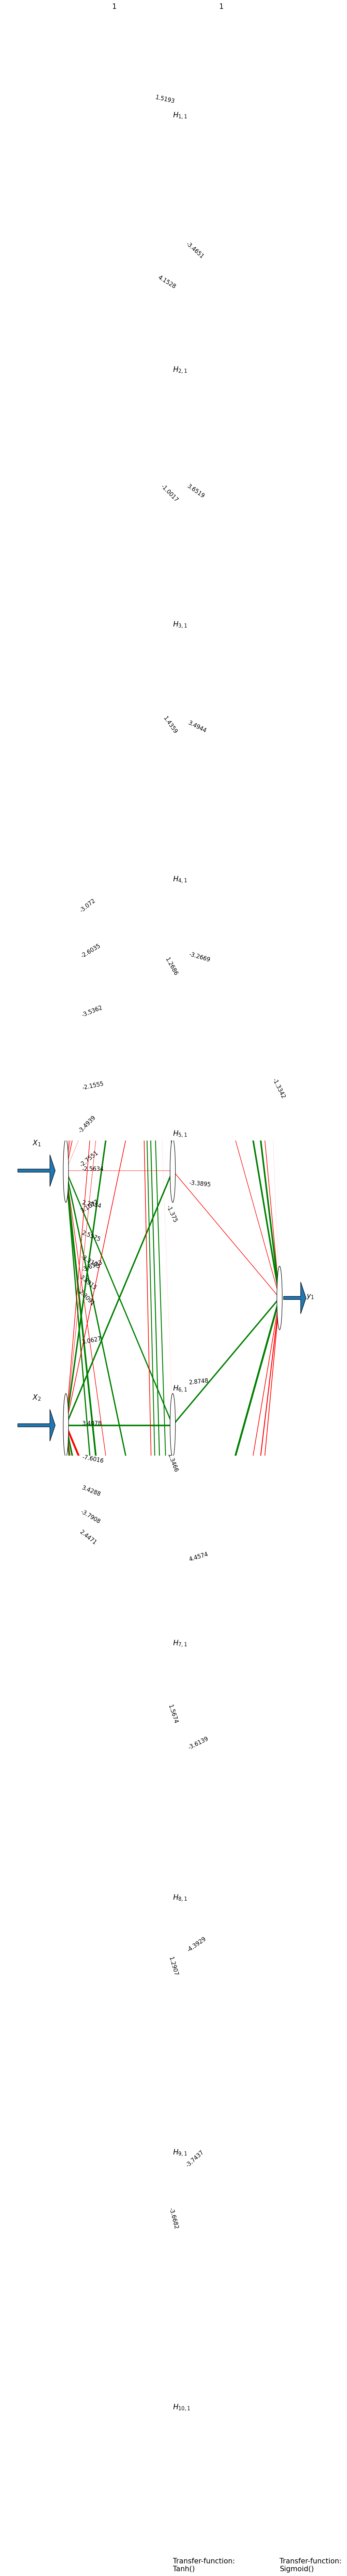


Generalization error/average error rate: 0.5%
Ran exercise 8.2.2.


In [6]:
# exercise 8.2.2
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import (
    draw_neural_net,
    train_neural_net,
    visualize_decision_boundary,
)

filename = importlib_resources.files("dtuimldmtools").joinpath("data/xor.mat")

plt.rcParams.update({"font.size": 12})

# read XOR DATA from matlab datafile
mat_data = loadmat(filename)
X = mat_data["X"]
y = mat_data["y"]

attributeNames = [name[0] for name in mat_data["attributeNames"].squeeze()]
classNames = [name[0] for name in mat_data["classNames"].squeeze()]
N, M = X.shape
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of the decision boundary for the several crossvalidation folds.
decision_boundaries = plt.figure(1, figsize=(10, 10))
# Determine a size of a plot grid that fits visualizations for the chosen number
# of cross-validation splits, if K=4, this is simply a 2-by-2 grid.
subplot_size_1 = int(np.floor(np.sqrt(K)))
subplot_size_2 = int(np.ceil(K / subplot_size_1))
# Set overall title for all of the subplots
plt.suptitle("Data and model decision boundaries", fontsize=20)
# Change spacing of subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0.5, hspace=0.25)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]

# Define the model structure
n_hidden_units = 10  # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to H hiden units
    # 1st transfer function, either Tanh or ReLU:
    torch.nn.Tanh(),  # torch.nn.ReLU(),
    torch.nn.Linear(n_hidden_units, 1),  # H hidden units to 1 output neuron
    torch.nn.Sigmoid(),  # final tranfer function
)
# Since we're training a neural network for binary classification, we use a
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print("Training model of type:\n{}\n".format(str(model())))

# Do cross-validation:
errors = []  # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the
# indices to be used for training and testing in each split, and calling
# the enumerate-method with this simply returns this indices along with
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold,
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Go to the file 'dtuimldmtools.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(
        model, loss_fn, X=X_train, y=y_train, n_replicates=3, max_iter=max_iter
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)  # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > 0.5).type(
        dtype=torch.uint8
    )  # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float) / len(y_test)).data.numpy()
    errors.append(error_rate)  # store error rate for current CV fold

    # Make a subplot for current cross validation fold that displays the
    # decision boundary over the original data, "background color" corresponds
    # to the output of the sigmoidal transfer function (i.e. before threshold),
    # white areas are areas of uncertainty, and a deaper red/blue means
    # that the network "is more sure" of a given class.
    plt.figure(decision_boundaries.number)
    plt.subplot(subplot_size_1, subplot_size_2, k + 1)
    plt.title("CV fold {0}".format(k + 1), color=color_list[k])
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    visualize_decision_boundary(
        predict,
        X,
        y,  # provide data, along with function for prediction
        attributeNames,
        classNames,  # provide information on attribute and class names
        train=train_index,
        test=test_index,  # provide information on partioning
        show_legend=k == (K - 1),
    )  # only display legend for last plot

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the error rate across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("Error rate")
summaries_axes[1].set_title("Test misclassification rates")

# Show the plots
# plt.show(decision_boundaries.number) # try these lines if the following code fails (depends on package versions)
# plt.show(summaries.number)
plt.show()

# Display a diagram of the best network in last fold
print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print(
    "\nGeneralization error/average error rate: {0}%".format(
        round(100 * np.mean(errors), 4)
    )
)

print("Ran exercise 8.2.2.")

### Impact of Increasing Hidden Units in Neural Networks (Exercises 8.2.3 and 8.2.4)

In **Exercises 8.2.3 and 8.2.4**, we increase the number of hidden units in the neural network model for the XOR classification task. The primary effects of increasing hidden units are:

1. **Enhanced Learning Capacity**:
   - Adding more hidden units allows the network to capture more complex patterns in the data. This is particularly beneficial for non-linearly separable datasets, like XOR, where additional complexity helps the model to better fit the data.

2. **Improved Decision Boundaries**:
   - With more hidden units, the network can create more flexible decision boundaries, which can more accurately separate the classes in challenging datasets.

3. **Risk of Overfitting**:
   - Although increased hidden units improve learning, too many units can lead to overfitting, where the model learns noise in the training data rather than general patterns.

4. **Increased Computation**:
   - A larger network requires more computational power and takes longer to train. This is a trade-off between model complexity and training efficiency.

By experimenting with different numbers of hidden units, we can observe these impacts and find a balance between model accuracy and complexity.

### Exercise 8.2.5: Wine Classification with Neural Network

In this exercise, we classify wine as either red or white using a neural network on the `wine2` dataset. The main steps are:

1. **Model Training with Hidden Units**:
   - Train the neural network with **2 hidden units** to classify wines and observe the classification boundaries.
2. **Feature Analysis**:
   - Identify which wine features the network relies on to distinguish red from white wines.
3. **Model Adjustment**:
   - Rerun the model with only **1 hidden unit** to observe changes in classification performance and boundary sharpness.

#### Expected Outcome:
With 2 hidden units, the network has greater flexibility to capture subtle distinctions between wine types. Reducing to 1 hidden unit limits the model’s complexity, which may reduce accuracy but provide insights into the network’s interpretability and boundary formation.

Training model of type:

Sequential(
  (0): Linear(in_features=11, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/3

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.112050086	0.0011646686
		2000	0.049705606	0.0005816256
		3000	0.031559844	0.0003543453
		4000	0.023676446	0.00022895829
		5000	0.019694455	0.00014487118
		6000	0.017550698	8.892854e-05
		7000	0.016388655	5.3982996e-05
		8000	0.014690928	0.00018108501
		9000	0.012816613	6.038119e-05
		10000	0.012307158	2.6106589e-05
		Final loss:
		10000	0.012307158	2.6106589e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.09685354	0.0011568619
		2000	0.04446028	0.0005332849
		3000	0.029765284	0.00029997042
		4000	0.023438103	0.00019117023
		5000	0.020010207	0.00012806822
		6000	0.018005028	8.802938e-05
		7000	0.015120369	0.00013967547
		8000	0.013713758	6.525874e-05
		9000	0.013104115	3.134133e-05
		10000	0.01275064	2.410303e-05
		Final los

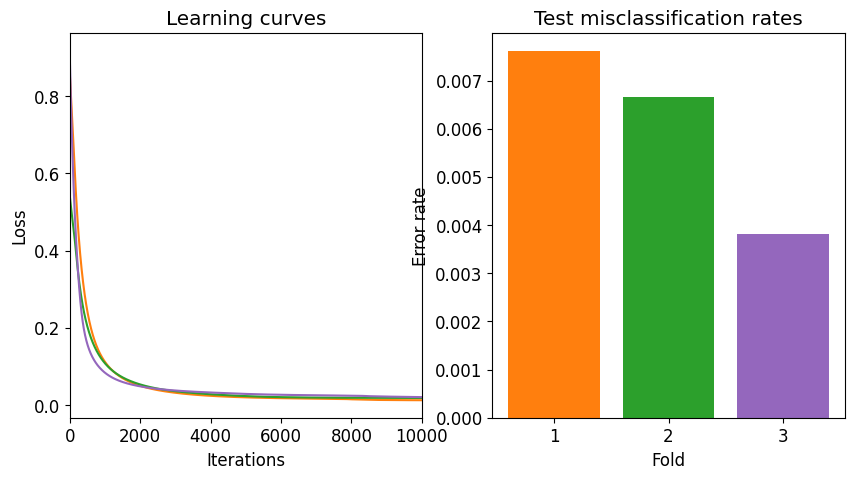

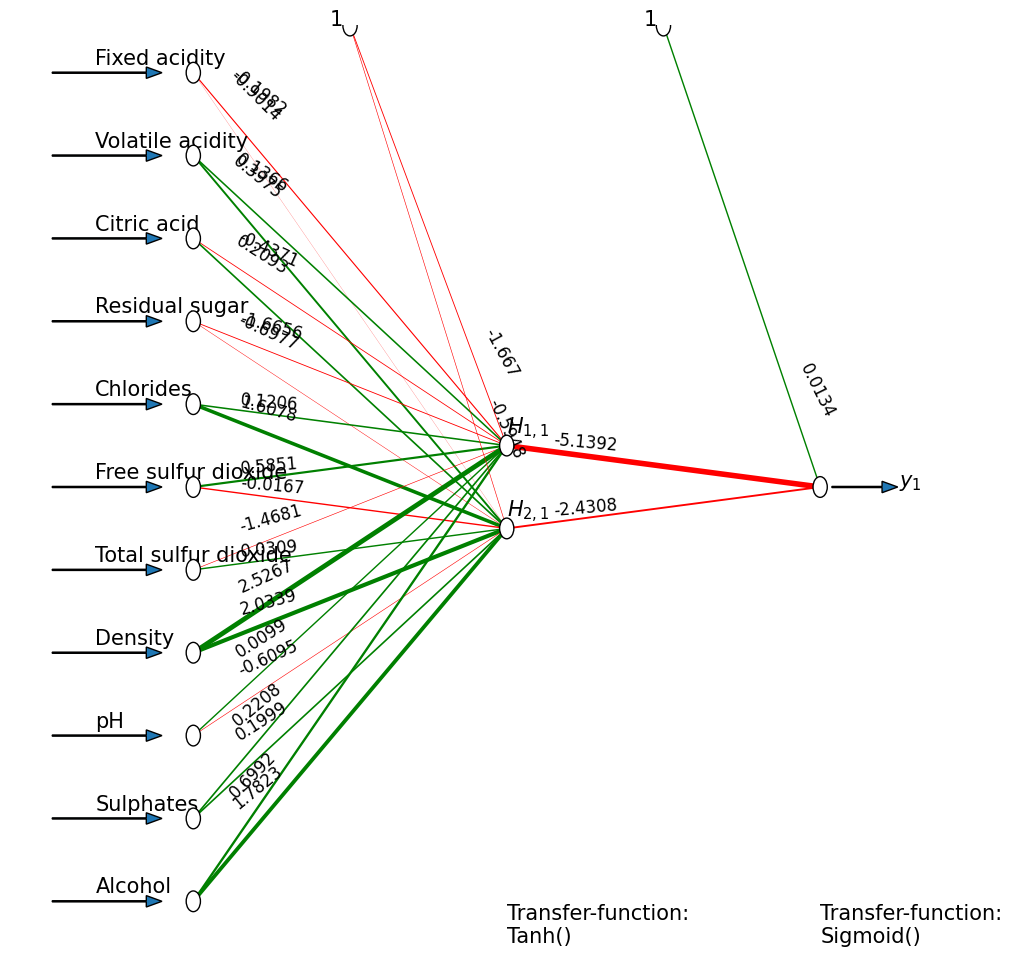


Generalization error/average error rate: 0.6028%
Ran Exercise 8.2.5


In [7]:
# exercise 8.2.5
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import draw_neural_net, train_neural_net

filename = importlib_resources.files("dtuimldmtools").joinpath("data/wine2.mat")


# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
X = mat_data["X"]
y = mat_data["y"]

# Downsample: X = X[1:20,:] y = y[1:20,:]
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X)

# Parameters for neural network classifier
n_hidden_units = 2  # number of hidden units
n_replicates = 2  # number of networks trained in each k-fold
max_iter = 10000  # stop criterion 2 (max epochs in training)

# K-fold crossvalidation
K = 3  # only five folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)
# Make figure for holding summaries (errors and learning curves)
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]

# Define the model, see also Exercise 8.2.2-script for more information.
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to H hiden units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # H hidden units to 1 output neuron
    torch.nn.Sigmoid(),  # final tranfer function
)
loss_fn = torch.nn.BCELoss()

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)
    y_test_est = (y_sigmoid > 0.5).type(dtype=torch.uint8)

    # Determine errors and errors
    y_test = y_test.type(dtype=torch.uint8)

    e = y_test_est != y_test
    error_rate = (sum(e).type(torch.float) / len(y_test)).data.numpy()
    errors.append(error_rate)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the error rate across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("Error rate")
summaries_axes[1].set_title("Test misclassification rates")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 3]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nGeneralization error/average error rate: {0}%".format(
        round(100 * np.mean(errors), 4)
    )
)

print("Ran Exercise 8.2.5")

### Exercise 8.2.6: Neural Network for Regression on Wine Data

In this exercise, we adapt the neural network to predict a continuous output—the **alcohol content** of wine—using different configurations of hidden units.

#### Steps:
1. **Network Configuration for Regression**:
   - Set the network’s output layer without an activation function, since regression does not require one.
   - Use a **Mean-Square-Error (MSE) loss** instead of cross-entropy loss for training, as it’s more suited to continuous targets.

2. **Model Training with Varying Hidden Units**:
   - Train the network with `n_hidden_units = 2` to predict the alcohol content, and evaluate the accuracy.
   - Increase to `n_hidden_units = 5` and observe any improvement in prediction accuracy.

3. **Model Interpretation**:
   - Analyze how the trained model interprets features to estimate alcohol content.
   - Compare the accuracy and model interpretability with different hidden unit configurations.

#### Expected Outcome:
   - Increasing the number of hidden units generally improves the model’s ability to capture complex relationships in the data, potentially enhancing prediction accuracy.
   - This exercise helps us understand how neural networks can be adapted for regression tasks and the effect of network complexity on regression performance.

Training model of type:

Sequential(
  (0): Linear(in_features=10, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	44.612377	0.0011826234
		2000	13.619664	0.001234989
		3000	3.702325	0.0013229579
		4000	1.1841968	0.0008466955
		5000	0.69258535	0.00027841612
		6000	0.5957258	0.000100443955
		7000	0.52741593	0.00015943535
		8000	0.4315356	0.00022840193
		9000	0.34716976	0.00019182377
		10000	0.29597703	0.00013168693
		Final loss:
		10000	0.29597703	0.00013168693

	Best loss: 0.29597702622413635


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	36.88539	0.0011040323
		2000	11.5908375	0.0012341305
		3000	3.1971688	0.0012695368
		4000	1.1530346	0.0006833372
		5000	0.74655193	0.00023172157
		6000	0.63519174	0.00013266827
		7000	0.53691864	0.00021565064
		8000	0.42027435	0.0002456483
		9000	0.34154007	0.00016576394
		10000	0.298765	0.00010811

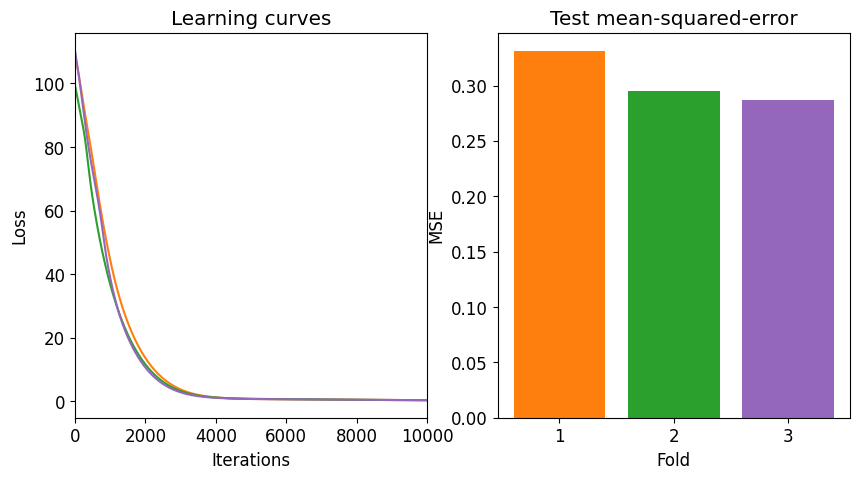

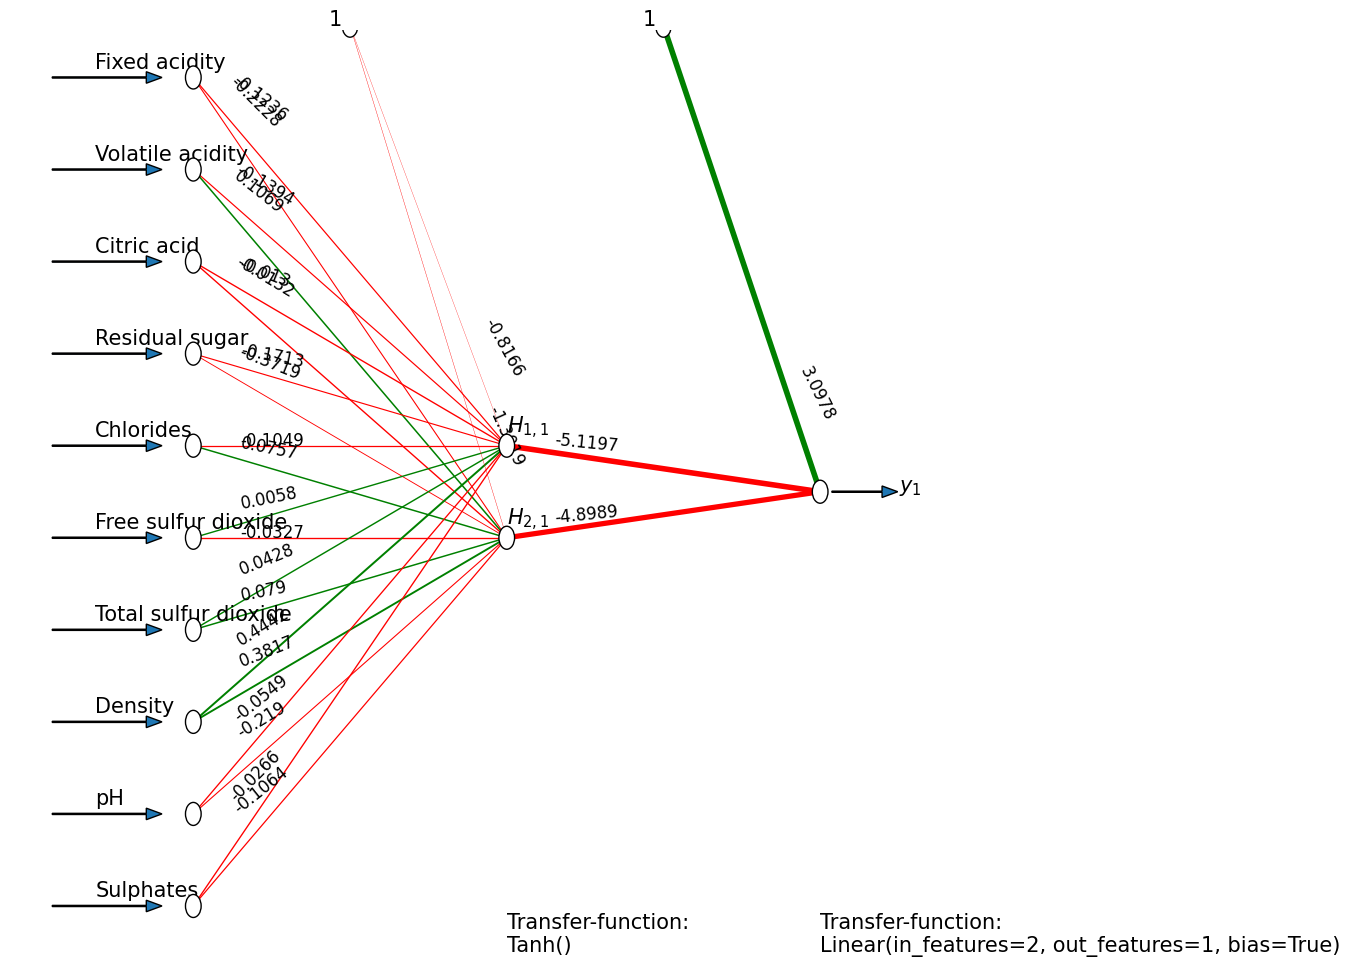


Estimated generalization error, RMSE: 0.5516999959945679


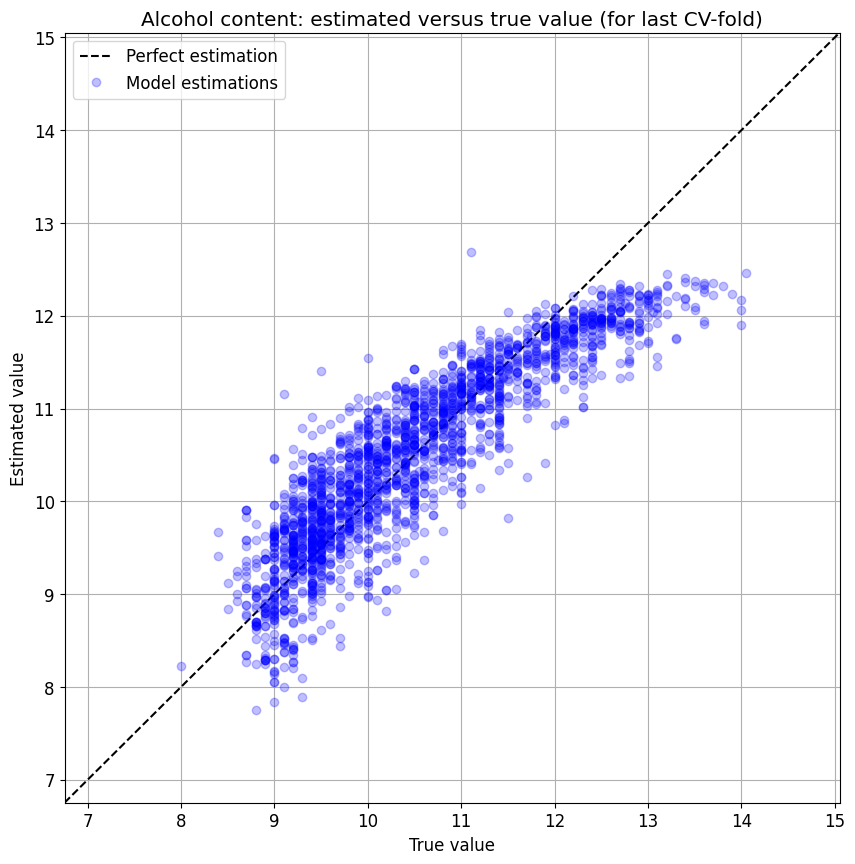

Ran Exercise 8.2.6


In [8]:
# exercise 8.2.6
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import draw_neural_net, train_neural_net

filename = importlib_resources.files("dtuimldmtools").joinpath("data/wine2.mat")


# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
X = mat_data["X"]
y = X[:, [10]]  # alcohol contents (target)
X = X[:, :10]  # the rest of features
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X)

## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X, 0)
    U, S, V = np.linalg.svd(Y, full_matrices=False)
    V = V.T
    # Components to be included as features
    k_pca = 3
    X = X @ V[:, :k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 2  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000

# K-fold crossvalidation
K = 3  # only three folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]
# Define the model
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the MSE across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("MSE")
summaries_axes[1].set_title("Test mean-squared-error")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nEstimated generalization error, RMSE: {0}".format(
        round(np.sqrt(np.mean(errors)), 4)
    )
)

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of
# the true/known value - these values should all be along a straight line "y=x",
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10, 10))
y_est = y_test_est.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.grid()

plt.show()

print("Ran Exercise 8.2.6")


### Exercise 8.3: Multiclass Classification with ANNs and Multinomial Regression

In this exercise, we apply neural networks (ANNs) and multinomial regression to a **multiclass classification** problem, where the model must distinguish between more than two classes.

#### Task 8.3.1 Overview:
1. **Data Loading**: Load synthetic multiclass data for training and evaluation.
2. **Neural Network Configuration**:
   - Implement an ANN with a **softmax output layer**, which converts the outputs into probabilities for each class.
3. **Loss Function**:
   - Use **cross-entropy loss** to optimize the network, as it is well-suited for multiclass classification tasks.
4. **Decision Boundary Visualization**:
   - Visualize decision boundaries to analyze how well the network separates different classes based on learned features.

#### Key Concepts:
- **Softmax Function**: Ensures outputs represent probabilities across classes, with each output between 0 and 1, summing to 1.
- **Cross-Entropy Loss**: Measures the difference between predicted class probabilities and true labels, guiding the model to improve classification accuracy.

This exercise demonstrates how ANNs can be adapted to multiclass classification tasks and the importance of softmax and cross-entropy loss for handling multiple


	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.89168465	0.0004063192
		2000	0.75903785	3.2037817e-05
		3000	0.74872935	5.652117e-06
		4000	0.74614155	2.1568587e-06
		Final loss:
		4895	0.7450799	9.59971e-07

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.76901656	6.138227e-05
		2000	0.7508771	8.890484e-06
		3000	0.7468987	3.032499e-06
		4000	0.745324	1.5194553e-06
		Final loss:
		4169	0.7451567	9.59872e-07

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.7667272	6.141008e-05
		2000	0.7504245	7.6250208e-06
		3000	0.7469855	2.7927674e-06
		4000	0.7454573	1.3592698e-06
		Final loss:
		4303	0.7451557	9.598733e-07
Number of miss-classifications for ANN:
	 0 out of 40


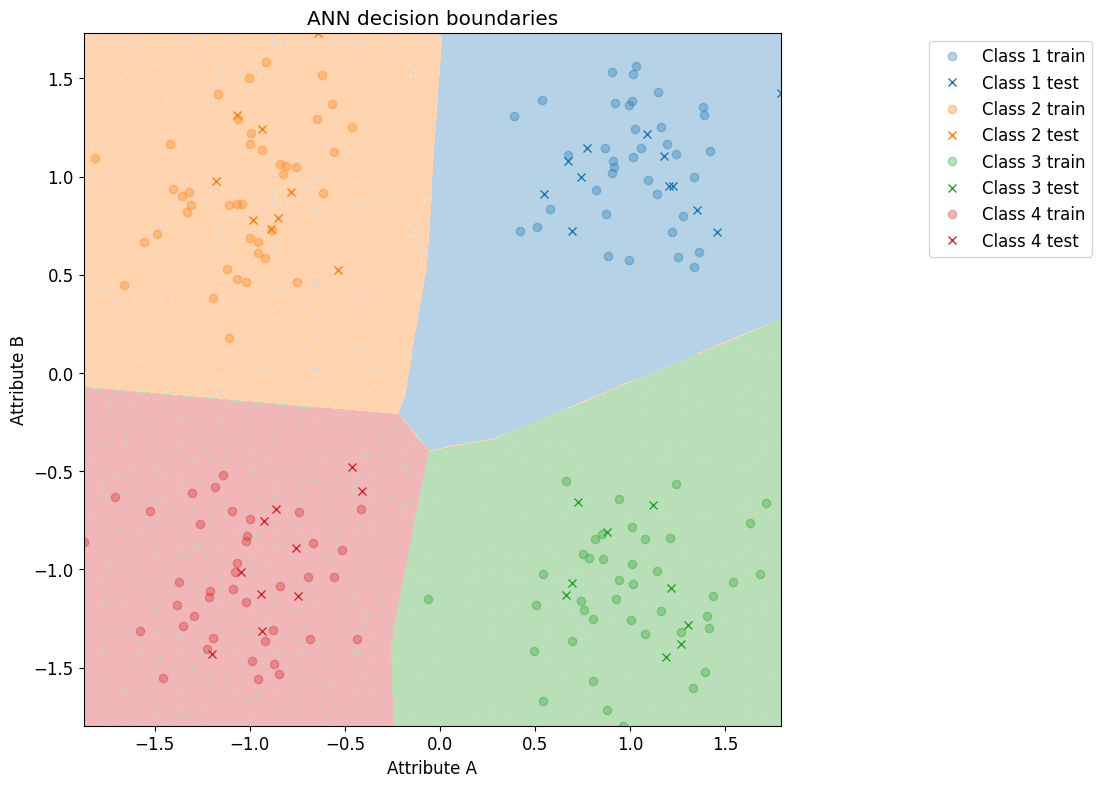

Ran Exercise 8.3.1


In [9]:
# exercise 8.3.1 Fit neural network classifiers using softmax output weighting
import importlib_resources
import numpy as np
import torch
from matplotlib.pyplot import figure, show, title
from scipy.io import loadmat

from dtuimldmtools import dbplotf, train_neural_net, visualize_decision_boundary

filename = importlib_resources.files("dtuimldmtools").joinpath("data/synth1.mat")


# Load Matlab data file and extract variables of interest
mat_data = loadmat(filename)
X = mat_data["X"]
X = X - np.ones((X.shape[0], 1)) * np.mean(X, 0)
X_train = mat_data["X_train"]
X_test = mat_data["X_test"]
y = mat_data["y"].squeeze()
y_train = mat_data["y_train"].squeeze()
y_test = mat_data["y_test"].squeeze()

attributeNames = [name[0] for name in mat_data["attributeNames"].squeeze()]
classNames = [name[0][0] for name in mat_data["classNames"]]

N, M = X.shape
C = len(classNames)
# %% Model fitting and prediction

# Define the model structure
n_hidden_units = 5  # number of hidden units in the signle hidden layer
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to H hiden units
    torch.nn.ReLU(),  # 1st transfer function
    # Output layer:
    # H hidden units to C classes
    # the nodes and their activation before the transfer
    # function is often referred to as logits/logit output
    torch.nn.Linear(n_hidden_units, C),  # C logits
    # To obtain normalised "probabilities" of each class
    # we use the softmax-funtion along the "class" dimension
    # (i.e. not the dimension describing observations)
    torch.nn.Softmax(dim=1),  # final tranfer function, normalisation of logit output
)
# Since we're training a multiclass problem, we cannot use binary cross entropy,
# but instead use the general cross entropy loss:
loss_fn = torch.nn.CrossEntropyLoss()
# Train the network:
net, _, _ = train_neural_net(
    model,
    loss_fn,
    X=torch.tensor(X_train, dtype=torch.float),
    y=torch.tensor(y_train, dtype=torch.long),
    n_replicates=3,
    max_iter=10000,
)
# Determine probability of each class using trained network
softmax_logits = net(torch.tensor(X_test, dtype=torch.float))
# Get the estimated class as the class with highest probability (argmax on softmax_logits)
y_test_est = (torch.max(softmax_logits, dim=1)[1]).data.numpy()
# Determine errors
e = y_test_est != y_test
print(
    "Number of miss-classifications for ANN:\n\t {0} out of {1}".format(sum(e), len(e))
)

predict = lambda x: (
    torch.max(net(torch.tensor(x, dtype=torch.float)), dim=1)[1]
).data.numpy()
figure(1, figsize=(9, 9))
visualize_decision_boundary(
    predict, [X_train, X_test], [y_train, y_test], attributeNames, classNames
)
title("ANN decision boundaries")

show()

print("Ran Exercise 8.3.1")
